In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime as dt

import yfinance as yf

import itertools

* In this assignment I use Pairs Trading.

## **1. Create functions and test on a single pair**

### 1.1. Functions to download data of multiple assets from YFinance

In [5]:
def extract_price_level(df: pd.DataFrame, price: str = "Close") -> pd.DataFrame:

    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("`df.columns` must be a MultiIndex with levels ['Price','Ticker']")
    out = df.xs(price, axis=1, level="Price")
    return out.reindex(sorted(out.columns), axis=1)


def data_YFinance(tickers: list[str], start: str, end: str, interval: str = "1d", price: str = "Close") -> pd.DataFrame:
 
    # 1) Download into a MultiIndex‐column DataFrame: (Price, Ticker)
    raw = yf.download(tickers=tickers, start=start, end=end, interval=interval, group_by="column",
                      auto_adjust=False, threads=True, progress=False)

    # 2) Extract only the requested price‐level
    price_df = extract_price_level(raw, price)

    return price_df

### 1.2. Functions to do OLS regression and extract the residuals

In [7]:
def LinReg_OLS(x: pd.Series, y: pd.Series, plot: bool = True, title: str = None, return_residual: bool = False):

    # align & drop missing
    x_clean, y_clean = x.align(y, join='inner')
    mask = x_clean.notna() & y_clean.notna()
    x_clean, y_clean = x_clean[mask], y_clean[mask]

    # fit
    X = sm.add_constant(x_clean)
    model = sm.OLS(y_clean, X).fit()

    # predictions + residuals
    yhat = model.predict(X)
    residuals = y_clean - yhat

    if plot:
        fig, ax = plt.subplots(figsize=(8,4), dpi=120)
        ax.scatter(x_clean, y_clean, alpha=0.7)
        ax.plot(x_clean, yhat, lw=1.5, label='Regression Line', color = 'purple')

        # eq text
        b, w = model.params['const'], model.params[x.name]
        eq = rf"$\hat{{{y.name}}} = {b:.3f} + {w:.3f}\,{x.name}$"
        ax.text(0.05, 0.95, eq,
                transform=ax.transAxes,
                va='top', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

        ax.set_title(title or f"{y.name} vs {x.name}", color = 'darkred')
        ax.set_xlabel(x.name, color = 'darkblue')
        ax.set_ylabel(y.name, color = 'darkblue')
        ax.legend()
        ax.grid(alpha=0.3)
        plt.show()

    if return_residual:
        return model, residuals
    return model

### 1.3. Functions to do Cointegration test (test stationarity of the residuals)

In [9]:
from statsmodels.tsa.stattools import adfuller

def Cointegration_test(residuals: pd.Series, maxlag: int = None, regression: str = 'c', 
                       autolag: str = 'AIC', significance: float = 0.05) -> dict:

    # drop missing
    resid = residuals.dropna()
    adf_res = adfuller(resid, maxlag=maxlag, regression=regression, autolag=autolag)

    adf_stat, p_value, used_lag, nobs, crit_vals, icbest = adf_res

    return {
        'adf_stat':    adf_stat,
        'p_value':     p_value,
        'used_lag':    used_lag,
        'nobs':        nobs,
        'crit_values': crit_vals,
        'is_stationary': p_value < significance
    }

### 1.4. Test on a single case

In [11]:
# Define assets (digital currencies) and time horizon (4 years)

tickers = ['BTC-USD', 'ETH-USD', 'DOT-USD', 'LTC-USD', 'ADA-USD', 'SOL-USD', 'XRP-USD']
start = dt.datetime(2021, 4, 1)
end = dt.datetime.now()

In [12]:
data = data_YFinance(tickers, start, end)

In [13]:
data

Ticker,ADA-USD,BTC-USD,DOT-USD,ETH-USD,LTC-USD,SOL-USD,XRP-USD
Date,,,,,,,
2021-04-01,1.189244,59095.808594,37.672878,1977.276855,204.112518,19.084902,0.579292
2021-04-02,1.196509,59384.312500,41.164284,2143.225586,213.228394,19.810223,0.616569
2021-04-03,1.173277,57603.890625,41.646030,2028.422485,197.148209,22.552277,0.590915
2021-04-04,1.191420,58758.554688,44.652210,2093.122803,204.042908,24.061323,0.646729
2021-04-05,1.214300,59057.878906,45.797230,2107.887207,221.069046,22.984283,0.920473
...,...,...,...,...,...,...,...
2025-04-23,0.697566,93699.109375,4.093156,1796.104248,83.225151,151.152725,2.217356
2025-04-24,0.721827,93943.796875,4.264550,1769.831665,84.331688,152.303635,2.204544
2025-04-25,0.714141,94720.500000,4.255543,1786.634521,86.328041,150.915009,2.183054


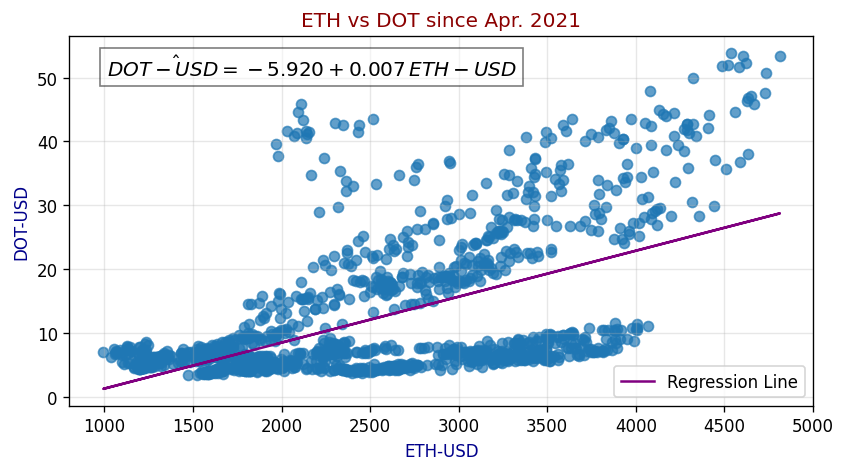

In [14]:
# Try a random pair
OLS, res =  (
    LinReg_OLS(data['ETH-USD'], data['DOT-USD'],
               plot = True, title = 'ETH vs DOT since Apr. 2021', return_residual = True)
)

In [15]:
res

Date
2021-04-01    29.357724
2021-04-02    31.654411
2021-04-03    32.962662
2021-04-04    35.503044
2021-04-05    36.541770
                ...    
2025-04-23    -2.917679
2025-04-24    -2.557140
2025-04-25    -2.687116
2025-04-26    -2.929126
2025-04-27    -2.983281
Length: 1488, dtype: float64

In [16]:
# Cointegration test = ADF test of the residual
Cointegration_test(res, regression='c', autolag='AIC', maxlag=None)

{'adf_stat': -2.898510957561534,
 'p_value': 0.04552142705191715,
 'used_lag': 20,
 'nobs': 1467,
 'crit_values': {'1%': -3.434815425568625,
  '5%': -2.8635121913888306,
  '10%': -2.567819976000063},
 'is_stationary': True}

## **2. Def a class to apply to multiple pairs for generalization**

In [18]:
class PairsTrading:
    def __init__(
        self, 
        price_df: pd.DataFrame, maxlag: int = None, regression: str = 'c',
        autolag: str = 'AIC',significance: float = 0.05):

        self.price_df    = price_df
        self.maxlag      = maxlag
        self.regression  = regression
        self.autolag     = autolag
        self.significance= significance

        self.coint_df = None
        self.hedge_df = None

# =========================================================================================================
# PART 1. RUN COINTEGRATION TEST FOR ALL PAIRS BY RUNNING OLS FOR ALL PAIRS AND TEST STATIONARITY OF THE RESIDUALS
    
    def cointegration_test_mult(self) -> pd.DataFrame:
        """
        Apply Cointegration test for multiple pairs
        """
        results = []
        for a, b in itertools.combinations(self.price_df.columns, 2):
            # regress y=a on x=b
            _, resid = LinReg_OLS(x=self.price_df[b], y=self.price_df[a],
                                  plot=False,return_residual=True)
            
            test = Cointegration_test(residuals=resid, maxlag=self.maxlag, regression=self.regression,
                                      autolag=self.autolag, significance=self.significance)
            
            results.append({
                'asset1 (y)': a,
                'asset2 (x)': b,
                'adf_stat':   test['adf_stat'],
                'p_value':    test['p_value'],
                'used_lag':   test['used_lag'],
                'is_coint':   test['is_stationary']
            })

        self.coint_df = (pd.DataFrame(results)
                         .sort_values('p_value')
                         .reset_index(drop=True))
        
        return self.coint_df

    def hedge_ratio_calc(self) -> pd.DataFrame:
        """
        Calculate the hedge ratio (bascially the weight of the OLS regression).
        """
        if self.coint_df is None:
            raise ValueError("Run cointegration_test_mult() first")

        hedge_results = []
        for _, row in self.coint_df[self.coint_df.is_coint].iterrows():
            a = row['asset1 (y)']
            b = row['asset2 (x)']
            # re-fit OLS a ~ b
            model, _ = LinReg_OLS(x=self.price_df[b],
                                  y=self.price_df[a],
                                  plot=False, return_residual=True)
            
            # slope on x=b is model.params[b]
            hedge_ratio = model.params[b]
            hedge_results.append({'asset1 (y)':  a,
                                  'asset2 (x)':  b,
                                  'hedge_ratio': hedge_ratio
                                 })

        self.hedge_df = pd.DataFrame(hedge_results).reset_index(drop=True)
        
        return self.hedge_df

    def plot_cointegrated(self, top_n: int = None):
        """
        OPTIONAL: in cases if we need to see the Regression plots of the cointegrated pairs.
        """
        if self.coint_df is None:
            raise ValueError("Run cointegration_test_mult() first")
        df = self.coint_df[self.coint_df.is_coint]
        if top_n is not None:
            df = df.head(top_n)

        for _, row in df.iterrows():
            a, b = row['asset1 (y)'], row['asset2 (x)']
            LinReg_OLS(x=self.price_df[b], y=self.price_df[a], plot=True, title=f"{a} vs {b}")

    def get_spreads(self) -> pd.DataFrame:
        """
        Compute the residual spread series for each cointegrated pair:
          spread_t = y_t - hedge_ratio * x_t
        """
        # make sure we have hedge ratios
        if self.hedge_df is None:
            self.hedge_ratio_calc()

        spreads = {}
        for _, row in self.hedge_df.iterrows():
            a = row['asset1 (y)']
            b = row['asset2 (x)']
            beta = row['hedge_ratio']

            # align the two series
            sa, sb = self.price_df[a].align(self.price_df[b], join='inner')
            sa, sb = sa.dropna(), sb.dropna()

            # compute spread = y (a) minus beta * x (b)
            spread = sa - beta * sb
            spreads[f"{a}_{b}"] = spread

        # combine into a single DataFrame
        return pd.DataFrame(spreads)

# =========================================================================================================
# PART 2. NORMALIZE THE SPREAD, GENERATING THE SIGNALS, THEN SHIFT THE SIGNALS
    
    def get_pair_df(self,
                    asset1: str, asset2: str, rolling_windows: list[int] | None = None) -> pd.DataFrame:
        """
        Return a DataFrame with columns [asset1, asset2, spread]
        and, if rolling_windows is given, rolling‐z columns for each window.

        """
        # 1) get raw price + spread
        pair_col = f"{asset1}_{asset2}"
        spreads = self.get_spreads()
        if pair_col not in spreads:
            raise KeyError(f"No spread for pair {pair_col}")
        s1 = self.price_df[asset1].rename(asset1)
        s2 = self.price_df[asset2].rename(asset2)
        sp = spreads[pair_col].rename('spread')

        # 2) align and drop NaNs
        df = pd.concat([s1, s2, sp], axis=1).dropna()

        # 3) optional rolling z-scores
        if rolling_windows:
            for w in rolling_windows:
                # rolling mean/std
                mu = df['spread'].rolling(window=w).mean()
                sigma = df['spread'].rolling(window=w).std()
                df[f"z_{w}"] = (df['spread'] - mu) / sigma

        return df


    def generate_pair_signals_positions(self,
                                        asset1: str, asset2: str, z_window: int, 
                                        entry_z: float = 2.0, exit_z: float = 0.5) -> pd.DataFrame:
        """
        1) Calls get_pair_df(asset1, asset2, rolling_windows=[z_window])
        2) Builds `signal_pair`, forward-fills it in a long_short style
        3) Creates `signal_<asset1>`, `signal_<asset2>`
        4) Shifts for `position_<asset1>`, `position_<asset2>`
        """
        # 1) Grab prices, spread and z_{z_window}
        df = self.get_pair_df(
            asset1, asset2,
            rolling_windows=[z_window]
        )
        z_col = f"z_{z_window}"
        spread = df['spread']
        z      = df[z_col]

        # 2) raw spread signal
        sig = pd.Series(0, index=df.index, name='signal_pair')
        sig[z >  entry_z] = -1
        sig[z < -entry_z] = +1

        # long_short‐style zero‐and‐ffill
        flip = ((sig.shift(1)>0)&(sig<0)) | ((sig.shift(1)<0)&(sig>0))
        sig[flip] = 0
        sig = sig.replace(0, np.nan).ffill().fillna(0).astype(int)

        # 3) per-asset signals
        sig_y = sig.rename(f"signal_{asset1}")
        sig_x = (-sig).rename(f"signal_{asset2}")

        # 4) next-day positions
        pos_y = sig_y.shift(1).fillna(0).astype(int).rename(f"position_{asset1}")
        pos_x = sig_x.shift(1).fillna(0).astype(int).rename(f"position_{asset2}")

        return pd.concat(
            [spread.rename('spread'), z.rename(z_col), sig, sig_y, sig_x, pos_y, pos_x],
            axis=1)

# =========================================================================================================
# PART 3. CALCULATE THE RETURN OF THE PAIR TRADING STRATEGIES FOR 2 CASES: 1) USING THE HEDGE RATIO; 2) USING A RATIO OF 1:1
    
    def pair_return(self,
                    asset1: str, asset2: str, z_window: int, entry_z: float = 2.0, exit_z: float = 0.5,
                    use_hedge: bool = True) -> pd.DataFrame:

        # 1) signals & positions (uses log‐prices internally)
        sig_df = self.generate_pair_signals_positions(
            asset1, asset2, z_window, entry_z, exit_z)

        # 2) log‐returns
        prices = self.price_df[[asset1, asset2]]
        log_ret = np.log(prices / prices.shift(1)).rename(
            columns={asset1: 'r1', asset2: 'r2'})

        # 3) pick hedge ratio
        if use_hedge:
            β = self.hedge_df.query(
                "(`asset1 (y)`==@asset1)&(`asset2 (x)`==@asset2)")['hedge_ratio'].item()
        else:
            β = 1.0

        # 4) assemble and compute PnL
        df = pd.concat([sig_df, log_ret], axis=1).dropna()
        pos_y = df[f"position_{asset1}"]
        pos_x = df[f"position_{asset2}"]

        # strategy return: pos_y * r1 + pos_x * (β * r2)
        # since pos_x == -pos_y, it's additive across days
        df['strategy_ret'] = pos_y * df['r1'] + pos_x * (β * df['r2'])

        return df

In [19]:
# Create the object Pairs Trading (PT)
PT = PairsTrading(data)

In [20]:
coint_df = PT.cointegration_test_mult()   # run batch ADF TEST
hedge_df = PT.hedge_ratio_calc()          # get hedge ratios for cointegrated pairs

In [21]:
coint_df[coint_df.is_coint]

# Display cointegrated pairs

,asset1 (y),asset2 (x),adf_stat,p_value,used_lag,is_coint
0,ADA-USD,LTC-USD,-3.813953,0.002768,13,True
1,ADA-USD,DOT-USD,-3.669583,0.004562,19,True
2,LTC-USD,SOL-USD,-3.433923,0.009855,21,True
3,DOT-USD,SOL-USD,-3.127418,0.024590,15,True
4,DOT-USD,ETH-USD,-2.898511,0.045521,20,True
5,LTC-USD,XRP-USD,-2.862812,0.049847,20,True


In [22]:
# Display hedge ratio of cointegrated pairs

hedge_df

,asset1 (y),asset2 (x),hedge_ratio
0,ADA-USD,LTC-USD,0.008936
1,ADA-USD,DOT-USD,0.045202
2,LTC-USD,SOL-USD,0.150556
3,DOT-USD,SOL-USD,0.035667
4,DOT-USD,ETH-USD,0.007199
5,LTC-USD,XRP-USD,33.311455


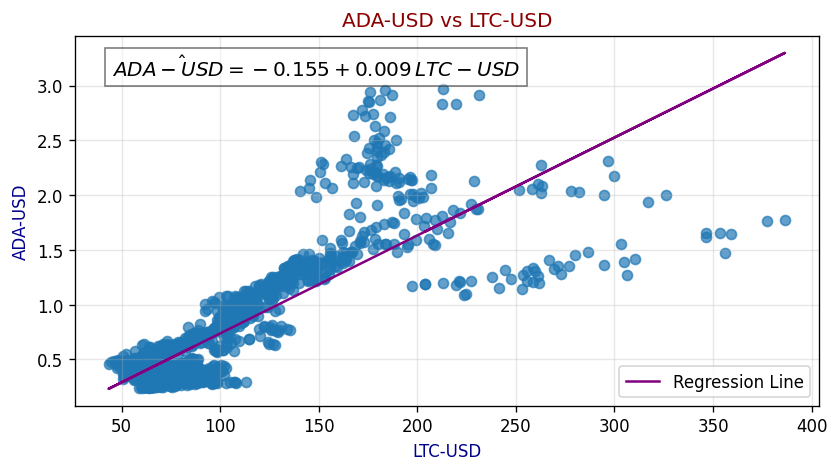

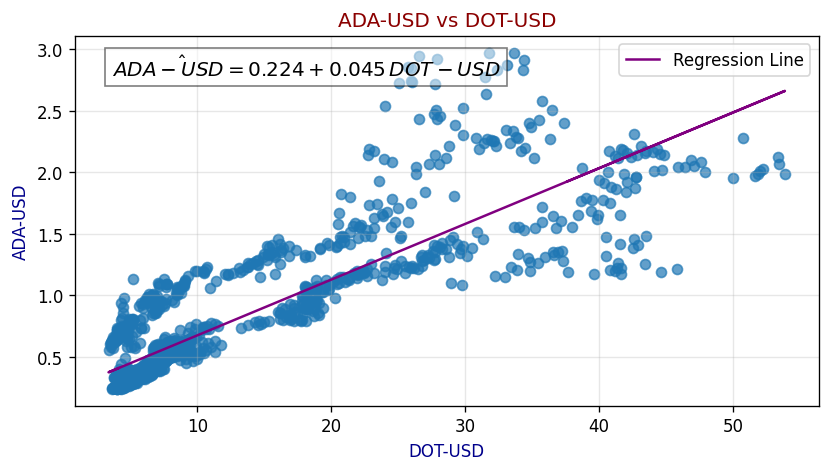

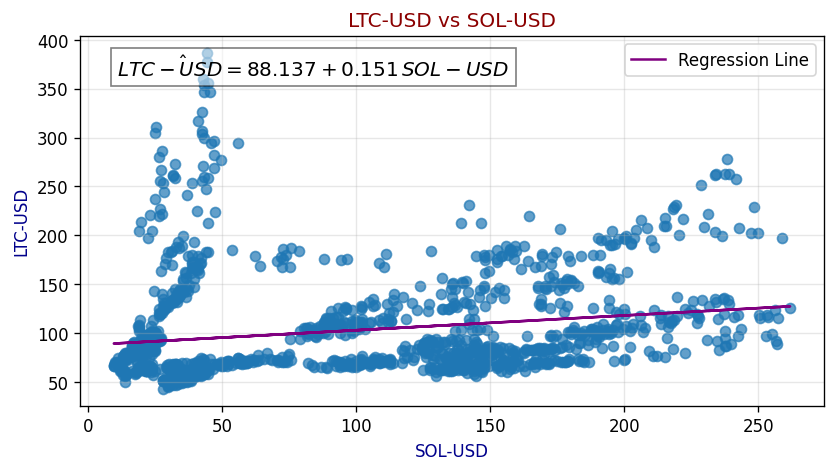

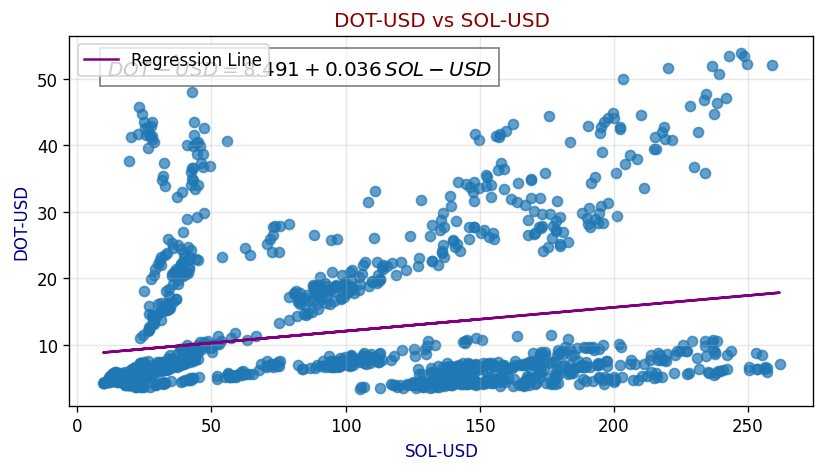

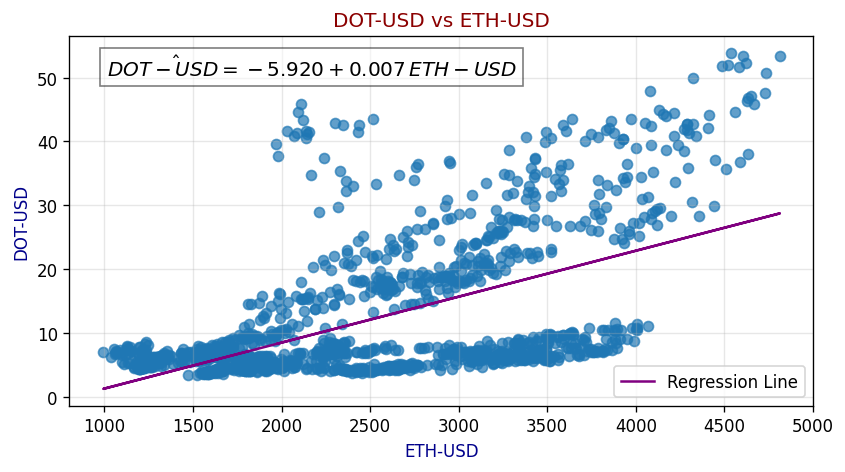

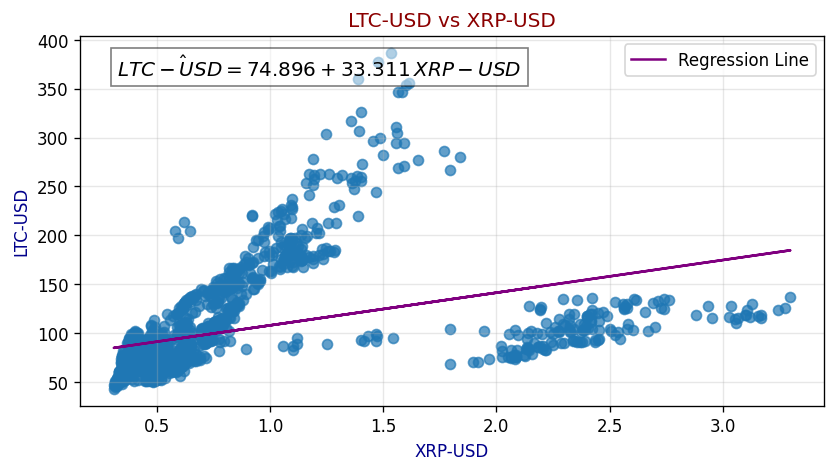

In [23]:
PT.plot_cointegrated(top_n=6)

In [24]:
# This line is optional. It is a part of the class but not needed to be run
# Just call for sanity check of the spread of the cointegrated pairs

spread_df = PT.get_spreads() 

In [25]:
spread_df

,ADA-USD_LTC-USD,ADA-USD_DOT-USD,LTC-USD_SOL-USD,DOT-USD_SOL-USD,DOT-USD_ETH-USD,LTC-USD_XRP-USD
Date,,,,,,
2021-04-01,-0.634682,-0.513648,201.239172,36.992182,23.437829,184.815459
2021-04-02,-0.708876,-0.664202,210.245846,40.457717,25.734517,192.689583
2021-04-03,-0.588417,-0.709210,193.752828,40.841664,27.042768,177.463969
2021-04-04,-0.631885,-0.826953,200.420332,43.794021,29.583149,182.499424
2021-04-05,-0.761148,-0.855830,217.608625,44.977455,30.621875,190.406751
...,...,...,...,...,...,...
2025-04-23,-0.046125,0.512547,60.468204,-1.297973,-8.837574,9.361796
2025-04-24,-0.031752,0.529060,61.401465,-1.167628,-8.477035,10.895116
2025-04-25,-0.057277,0.521782,63.606884,-1.127107,-8.607011,13.607336


#### Log‐Returns and Additivity

We compute all returns as **log‐returns**  
$$
r_t = \ln\!\bigl(P_t / P_{t-1}\bigr)
$$
because log‐returns are **additive** over time:
$$
\sum_{t=1}^T r_t 
= \ln\!\Bigl(\tfrac{P_T}{P_0}\Bigr)
$$  
This makes it trivial to aggregate daily P&L into a cumulative P&L series.

---

#### Strategy Return Calculation

Let:
- $y$ = asset1 price, with log‐return $r_{y,t}$
- $x$ = asset2 price, with log‐return $r_{x,t}$  
- $\beta$ = hedge ratio (OLS slope), or $\beta=1$ when using a 1:1 ratio  
- $\mathrm{pos}_{y,t}\in\{+1,0,-1\}$ = next‐day position in $y$ 
- $\mathrm{pos}_{x,t} = -\,\mathrm{pos}_{y,t}$ = next‐day position in $x$

Then the strategy log‐return on day $t$ is  
$$
\mathrm{strategy\_ret}_t 
= \mathrm{pos}_{y,t}\,r_{y,t}
\;+\;\mathrm{pos}_{x,t}\,\bigl(\beta\,r_{x,t}\bigr)
$$

In [27]:
# Suppose that I pick the pair ADA-USD and DOT-USD

# The parameters entry_z and exit_z are subjected to optimization
res_with_hedge = PT.pair_return('ADA-USD','DOT-USD', z_window=365, entry_z=3, exit_z=0.5, use_hedge=True)

# backtest with a 1:1 hedge instead
res_flat_hedge = PT.pair_return('ADA-USD','DOT-USD', z_window=365, entry_z=3, exit_z=0.5, use_hedge=False)

In [28]:
res_with_hedge

,spread,z_365,signal_pair,signal_ADA-USD,signal_DOT-USD,position_ADA-USD,position_DOT-USD,r1,r2,strategy_ret
Date,,,,,,,,,,
2022-03-31,0.178933,-0.276638,0,0,0,0,0,-0.041626,-0.053283,-0.000000
2022-04-01,0.170211,-0.300096,0,0,0,0,0,0.020435,0.032989,0.000000
2022-04-02,0.132427,-0.386563,0,0,0,0,0,-0.008114,0.028104,0.000000
2022-04-03,0.136880,-0.384463,0,0,0,0,0,0.025565,0.024589,0.000000
2022-04-04,0.188767,-0.281957,0,0,0,0,0,0.022515,-0.024005,0.000000
...,...,...,...,...,...,...,...,...,...,...
2025-04-23,0.512547,0.755076,-1,-1,1,-1,1,0.024910,0.018667,-0.024067
2025-04-24,0.529060,0.823239,-1,-1,1,-1,1,0.034188,0.041020,-0.032334
2025-04-25,0.521782,0.786883,-1,-1,1,-1,1,-0.010705,-0.002114,0.010609


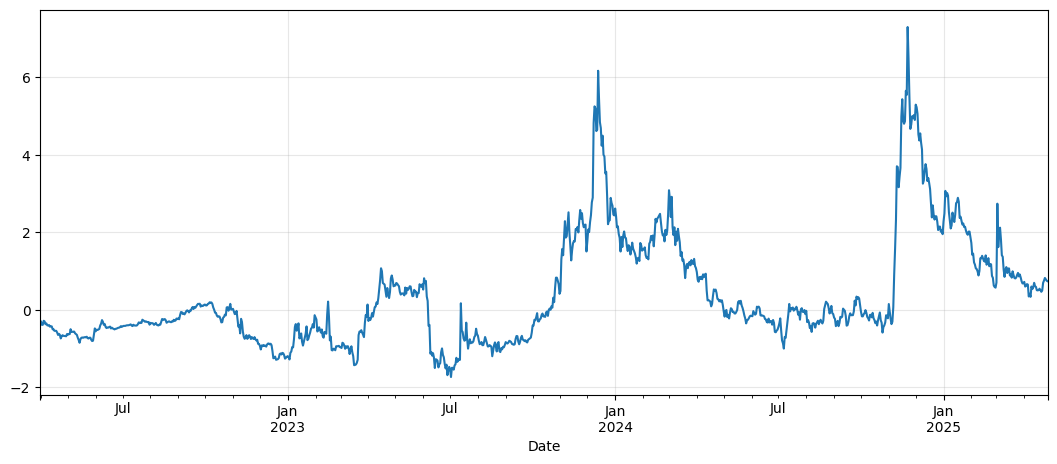

In [29]:
# First we plot the normalize z over recent 1 year to see if the spread indicates cointegration
res_with_hedge.z_365.plot(figsize = (13,5))
plt.grid(alpha = 0.3);

In [30]:
def strategy_performance(df: pd.DataFrame, strat_ret_col: str = 'strategy_ret', trading_days: int = 252,
                         risk_free: float = 0.0) -> tuple[pd.DataFrame, pd.DataFrame]:

    perf = pd.DataFrame(index=df.index)
    perf['strategy_log_ret'] = df[strat_ret_col]

    # cumulative growth factor and return
    perf['cum_factor'] = perf['strategy_log_ret'].cumsum().apply(np.exp)
    perf['cum_return'] = perf['cum_factor'] - 1

    # drawdown
    perf['high_watermark'] = perf['cum_factor'].cummax()
    perf['drawdown'] = (perf['cum_factor'] - perf['high_watermark']) / perf['high_watermark']
    max_dd = perf['drawdown'].min()

    # daily stats
    mean_lr = perf['strategy_log_ret'].mean()
    std_lr  = perf['strategy_log_ret'].std()

    # annualized stats
    ann_return = mean_lr * trading_days
    ann_std    = std_lr * np.sqrt(trading_days)
    daily_rf   = risk_free / trading_days
    ann_sharpe = ((mean_lr - daily_rf) / std_lr) * np.sqrt(trading_days)

    # pack metrics
    metrics = pd.DataFrame({
        'Value': [
            perf['cum_return'].iloc[-1],
            ann_return,
            ann_std,
            ann_sharpe,
            max_dd
        ]
    }, index=[
        'Strategy Cum Ret',
        'Annualized Return',
        'Annualized Std',
        'Annualized Sharpe',
        'Max Drawdown'
    ])

    return perf, metrics

In [31]:
perf_df, stats = strategy_performance(df=res_with_hedge, strat_ret_col='strategy_ret', trading_days=365, risk_free=0)

In [32]:
perf_df.head()

,strategy_log_ret,cum_factor,cum_return,high_watermark,drawdown
Date,,,,,
2022-03-31,-0.0,1.0,0.0,1.0,0.0
2022-04-01,0.0,1.0,0.0,1.0,0.0
2022-04-02,0.0,1.0,0.0,1.0,0.0
2022-04-03,0.0,1.0,0.0,1.0,0.0
2022-04-04,0.0,1.0,0.0,1.0,0.0


In [33]:
stats

,Value
Strategy Cum Ret,-0.236791
Annualized Return,-0.087751
Annualized Std,0.647609
Annualized Sharpe,-0.135499
Max Drawdown,-0.734666


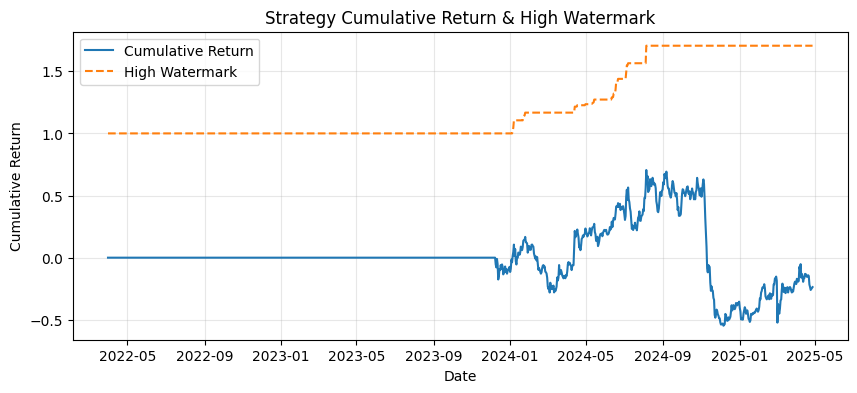

In [66]:
# 1) Cumulative return + high–watermark
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(perf_df.index, perf_df['cum_return'],      label='Cumulative Return')
ax.plot(perf_df.index, perf_df['high_watermark'],  label='High Watermark', linestyle='--')
ax.set_title("Strategy Cumulative Return & High Watermark")
ax.set_ylabel("Cumulative Return")
ax.set_xlabel("Date")
ax.legend()
ax.grid(alpha=0.3)

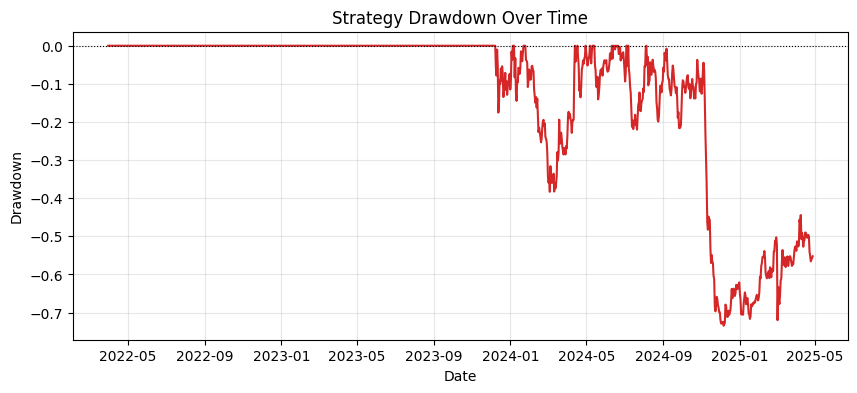

In [64]:
# 2) Drawdown over time
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(perf_df.index, perf_df['drawdown'], color='tab:red')
ax.set_title("Strategy Drawdown Over Time")
ax.set_ylabel("Drawdown")
ax.set_xlabel("Date")
ax.axhline(0, color='black', linewidth=0.8, linestyle=':')
ax.grid(alpha=0.3)